# **Setup**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Path to the data directory
data_dir = Path("Datasets\ColorCaptcha\\")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
print(images[:3])
print(labels[:3])

['Datasets\\ColorCaptcha\\111J8.jpg', 'Datasets\\ColorCaptcha\\111XM.jpg', 'Datasets\\ColorCaptcha\\113EV.jpg']
['111J8', '111XM', '113EV']


In [3]:
characters = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  113062
Number of labels found:  113062
Number of unique characters:  60
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print(max_length)

5


# **Preprocessing**

In [5]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [6]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_test, y_train, y_test = split_data(np.array(images), np.array(labels))

In [7]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [8]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# **Load baseline model**

In [9]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

# Register the custom layer
keras.utils.get_custom_objects()["CTCLayer"] = CTCLayer

In [10]:
# Load the model
loaded_model = keras.models.load_model('ModelWeights\\NewBaselineModelWeights.h5')

In [11]:
# Predict on test set
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    loaded_model.get_layer(name="image").input, loaded_model.get_layer(name="dense2").output
)

In [12]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# **Inference**

In [13]:
import time

In [14]:
start_time = time.time()

#  Check results on test_dataset
pred_texts, orig_texts = [], []
for batch in test_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_txts = decode_batch_predictions(preds)
    pred_texts.append(pred_txts)

    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

end_time = time.time()

1/1 [==============================] - 0s 68ms/step


**Inference time**

In [15]:
inference_time = end_time - start_time
print("Inference time: {:.4f} seconds".format(inference_time))

Inference time: 146.2291 seconds


In [28]:
pred_texts = np.array(pred_texts).flatten()
print(pred_texts)

[list(['KSOAk', 't26YF', '6XIAz', 'DmqU9', 'j2ahw', 'YzhtX', 'rsIP7', 'KYmnv', 'WiGjT', '57uDw', 'WtKZS', 'Wssjn', 'GfXzS', 'txyXO', 'pjMRf', 'VISRR'])
 list(['7PXMH', 'A8wpe', '7ljYE', 'F1Aym', 'bt4OV', '93VWy', '7jD9M', 'UPv5l', 'KH1q2', 'XVnDX', 'dEGOb', 'WjzF2', 'XU2qL', 'Vthw[UNK]', '6aZOJ', 'CUTUs'])
 list(['8MMwf', 'pLVr[UNK]', 't5hyz', 'ZcGXe', 'd5znX', 'nkU3Z', '1iMlJ', 'Sudni', 'tGTem', 'qweNA', 'a7XuS', 'GiXwP', 'BN3ww', 'Y9FUL', 'ZGVkT', 'cXTUY'])
 list(['L78B3', 'smyky', 'cyfDO', '5Wxac', '8TrKT', 'elAL7', 'ABEI8', 'Cwufe', 'jYKtX', '2I6Dv', 'HOsPL', 'NYXhj', '9AUTb', '6F12s', '5OVqA', '1smGB'])
 list(['m5ywB', '7I3an', '6aCMA', 'EFQ8u', 'bcj7m', 'M2l1Y', 'dgIE9', 'VZEU7', 'barbx', 'vC3dz', 'hJEv4', 'Xechd', 'rlff5', '5sgAO', '5e5bw', 'NjVQa'])
 list(['5d5ci', 'VrzhP', 'kPdgP', 'SjAjY', 'XKwka', 'V7TfJ', 'A5xNX', 'gZzDb', 'y5453', 'TZ3NI', 'U9jdP', 'O7thD', '79jS5', 'JEAwV', 'SzjC4', 'V6I7c'])
 list(['OmRdC', 'QJPar', 'b6gfA', 'cIMzJ', 'D9jp2', 'M4CQx', 'xn8rp', 'X5SVO', '

In [33]:
pred_texts = [item for sublist in pred_texts for item in sublist]
print(len(pred_texts))
print(pred_texts)

11307
['KSOAk', 't26YF', '6XIAz', 'DmqU9', 'j2ahw', 'YzhtX', 'rsIP7', 'KYmnv', 'WiGjT', '57uDw', 'WtKZS', 'Wssjn', 'GfXzS', 'txyXO', 'pjMRf', 'VISRR', '7PXMH', 'A8wpe', '7ljYE', 'F1Aym', 'bt4OV', '93VWy', '7jD9M', 'UPv5l', 'KH1q2', 'XVnDX', 'dEGOb', 'WjzF2', 'XU2qL', 'Vthw[UNK]', '6aZOJ', 'CUTUs', '8MMwf', 'pLVr[UNK]', 't5hyz', 'ZcGXe', 'd5znX', 'nkU3Z', '1iMlJ', 'Sudni', 'tGTem', 'qweNA', 'a7XuS', 'GiXwP', 'BN3ww', 'Y9FUL', 'ZGVkT', 'cXTUY', 'L78B3', 'smyky', 'cyfDO', '5Wxac', '8TrKT', 'elAL7', 'ABEI8', 'Cwufe', 'jYKtX', '2I6Dv', 'HOsPL', 'NYXhj', '9AUTb', '6F12s', '5OVqA', '1smGB', 'm5ywB', '7I3an', '6aCMA', 'EFQ8u', 'bcj7m', 'M2l1Y', 'dgIE9', 'VZEU7', 'barbx', 'vC3dz', 'hJEv4', 'Xechd', 'rlff5', '5sgAO', '5e5bw', 'NjVQa', '5d5ci', 'VrzhP', 'kPdgP', 'SjAjY', 'XKwka', 'V7TfJ', 'A5xNX', 'gZzDb', 'y5453', 'TZ3NI', 'U9jdP', 'O7thD', '79jS5', 'JEAwV', 'SzjC4', 'V6I7c', 'OmRdC', 'QJPar', 'b6gfA', 'cIMzJ', 'D9jp2', 'M4CQx', 'xn8rp', 'X5SVO', 'gIi27', '7XjKE', 'hEKip', '2kryy', 'AKwVY', '44e

In [36]:
pred_texts = np.array(pred_texts)

In [29]:
# pred_texts = np.char.replace(pred_texts, '[UNK]', '_')
# print(pred_texts)

In [30]:
orig_texts = np.array(orig_texts)
print(orig_texts)

['KSOAk' 't26YF' '6XiaZ' ... 'lCOrt' 'hJqFK' 'rmxqs']


In [32]:
print(len(orig_texts))

11307


# **Word accuracy**

In [34]:
def WordAccuracy(pred, gt):
    return np.sum(pred == gt) / (pred.shape[0])

In [37]:
print("Accuracy on word: ", WordAccuracy(pred_texts,orig_texts)) 

Accuracy on word:  0.5947643052976033


# **Char accuracy**

In [38]:
def Char_accuracy(array1, array2):
    total_matching_characters = 0
    total_char = len(array1[0]) * len(array1)
    for str1, str2 in zip(array1, array2):
        matching_characters = sum(a == b for a, b in zip(str1, str2))
        total_matching_characters += matching_characters
    return total_matching_characters / total_char

In [39]:
print("Accuracy on characters: ", Char_accuracy(pred_texts,orig_texts)) 

Accuracy on characters:  0.8640134429999116


# **Plot some results**

1/1 [==============================] - 0s 141ms/step


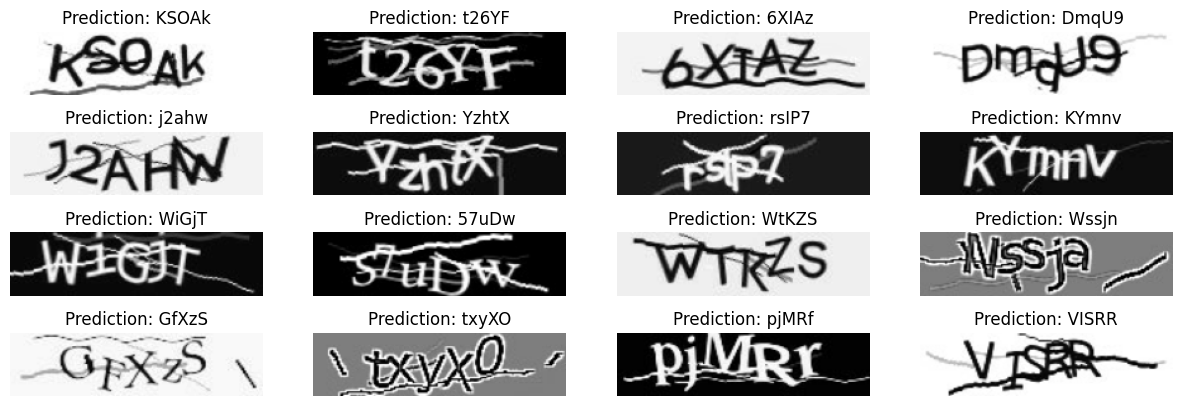

In [40]:
#  Let's check results on some validation samples
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

# **Predict on 1 image**

In [ ]:
def encode_one_image(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    return img

In [ ]:
def plot_result(img_path):
    test_img = tf.reshape(encode_one_image(img_path), (1, 200, 50, 1))

    preds = prediction_model.predict(test_img)
    pred_texts = decode_batch_predictions(preds)


    # Plot the tensor using imshow()
    test_img = (test_img[0, :, :, 0] * 255).numpy().astype(np.uint8)
    test_img = test_img.T
    
    plt.imshow(test_img, cmap="gray")
    plt.axis('off')  # Turn off the axis labels
    plt.title(pred_texts)
    plt.show()

In [ ]:
image_path = "Datasets\ColorCaptcha\\1a1SZ.jpg"
# image_path = "test2.png"
plot_result(image_path)

# **CTC LOSS**

In [ ]:
loaded_model.summary()

In [ ]:
ctc_image = tf.reshape(encode_one_image(image_path), (1, 200, 50, 1))
print(ctc_image.shape)

In [ ]:
extracted_features = prediction_model.predict(ctc_image)

In [ ]:
print(extracted_features.shape)
print(type(extracted_features))

In [ ]:
plt.imshow(extracted_features.reshape(50,62), cmap='viridis')
# plt.axis('off')
plt.title("Extracted feature")
plt.show()

In [ ]:
label = char_to_num(tf.strings.unicode_split('1a1SZ', input_encoding="UTF-8"))
print(label)

In [ ]:
print(extracted_features.shape)

In [ ]:
batch_len = tf.cast(tf.shape(label)[0], dtype="int64")
print(batch_len)
input_length = tf.cast(tf.shape(extracted_features)[1], dtype="int64")
print(input_length)
label_length = tf.cast(tf.shape(extracted_features)[1], dtype="int64")
print(label_length)

In [ ]:
input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

In [ ]:
print(input_length)

In [ ]:
print(label_length)